# 构建CNN模型

In [10]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv1D,InputLayer,Convolution1D,MaxPooling1D,BatchNormalization,Concatenate,Input

# seq_len, filter_len = 118+18, 8
seq_len, filter_len = 118, 4
# nbr_filters, nodes = 100, 300
# dropout = (0.2, 0)
# # dropout = (0, 0)
# layers, border_mode = 2 , 'same'

nbr_filters, nodes = 200, 100
dropout = (0.05, 0)
# dropout = (0, 0)
layers, border_mode = 3 , 'same'

''' Build model archicture and fit.'''
model = Sequential()
if layers >= 1:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
if layers >= 2:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(Dropout(dropout[0]))
if layers >= 3:
    model.add(Conv1D(activation="relu", input_shape=(seq_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    model.add(Dropout(dropout[0]))
model.add(Flatten())

model.add(Dense(nodes,kernel_initializer='glorot_normal',bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(Dropout(dropout[1]))

model.add(Dense(1,kernel_initializer='glorot_normal',bias_initializer='zeros'))
model.add(Activation('linear'))
model.summary()

#compile the model
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-06)
model.compile(loss="mean_squared_error", optimizer=adam)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 118, 200)          3400      
                                                                 
 conv1d_5 (Conv1D)           (None, 118, 200)          160200    
                                                                 
 dropout_4 (Dropout)         (None, 118, 200)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 118, 200)          160200    
                                                                 
 dropout_5 (Dropout)         (None, 118, 200)          0         
                                                                 
 flatten_2 (Flatten)         (None, 23600)             0         
                                                                 
 dense_4 (Dense)             (None, 100)              

# 训练模型

In [11]:
import os
import random
import numpy as np
import pandas as pd
from sklearn import preprocessing


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        lst = [nuc_d[x] for x in seq]
        if seq_len>len(seq):
            lst += [nuc_d['n']]*(seq_len-len(seq))
        a = np.array(lst)
        vectors[i] = a
    return vectors


set_seed(42)
name="pl3-1-2"
datadir=f"/Users/john/data/sev/results/{name}/{name}_"
# datadir="./data"
e_train = pd.read_csv(f"{datadir}train.csv")
e_test= pd.read_csv(f"{datadir}test.csv")
print(e_train.shape, e_test.shape)

seq_e_train = one_hot_encode(e_train,seq_len=seq_len)
seq_e_test = one_hot_encode(e_test, seq_len=seq_len)
label = 'score' # abs_score:0.2987 0.6760
e_test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test.loc[:,label].values.reshape(-1,1))
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,label].values.reshape(-1,1))
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='min', verbose=1, 
                          restore_best_weights = True)
history = model.fit(seq_e_train, e_train['scaled_rl'], batch_size=64, epochs=10,callbacks=[earlyStop], verbose=1,
                    validation_data=(seq_e_test,e_test["scaled_rl"]), shuffle=True)


(3025, 8) (160, 8)
Epoch 1/10
48/48 [==============================] - 13s 251ms/step - loss: 0.9834 - val_loss: 0.6388
Epoch 2/10
48/48 [==============================] - 10s 214ms/step - loss: 0.6216 - val_loss: 0.4557
Epoch 3/10
48/48 [==============================] - 11s 224ms/step - loss: 0.5561 - val_loss: 0.3841
Epoch 4/10
48/48 [==============================] - 11s 219ms/step - loss: 0.5325 - val_loss: 0.3983
Epoch 5/10
48/48 [==============================] - 12s 252ms/step - loss: 0.5143 - val_loss: 0.5156
Epoch 6/10
48/48 [==============================] - 12s 247ms/step - loss: 0.5147 - val_loss: 0.3561
Epoch 7/10
48/48 [==============================] - 11s 231ms/step - loss: 0.5066 - val_loss: 0.3412
Epoch 8/10
48/48 [==============================] - 11s 222ms/step - loss: 0.4937 - val_loss: 0.3593
Epoch 9/10
48/48 [==============================] - 11s 229ms/step - loss: 0.4780 - val_loss: 0.3986
Epoch 10/10
48/48 [==============================] - 11s 226ms/step - lo

# 评估训练效果

In [12]:
import scipy.stats as stats
from sklearn import preprocessing

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

e_test = test_data(df=e_test, model=model, obs_col=label,test_seq=seq_e_test)
r = r2(e_test[label], e_test['pred'])
pr =  stats.pearsonr(e_test[label], e_test['pred'])
print('test r-squared = ', r, "pearsonR = ", pr[0])
e_train = test_data(df=e_train, model=model, obs_col=label,test_seq=seq_e_train)
r = r2(e_train[label], e_train['pred'])
pr =  stats.pearsonr(e_train[label], e_train['pred'])
print('train r-squared = ', r, "pearsonR = ", pr[0])

5/5 [==============================] - 0s 31ms/step
test r-squared =  0.6662451454920574 pearsonR =  0.8162384121640304
95/95 [==============================] - 3s 29ms/step
train r-squared =  0.5578446172545195 pearsonR =  0.746889963284097


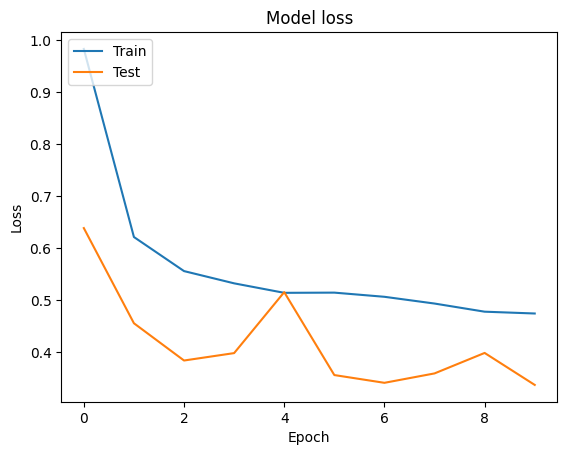

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

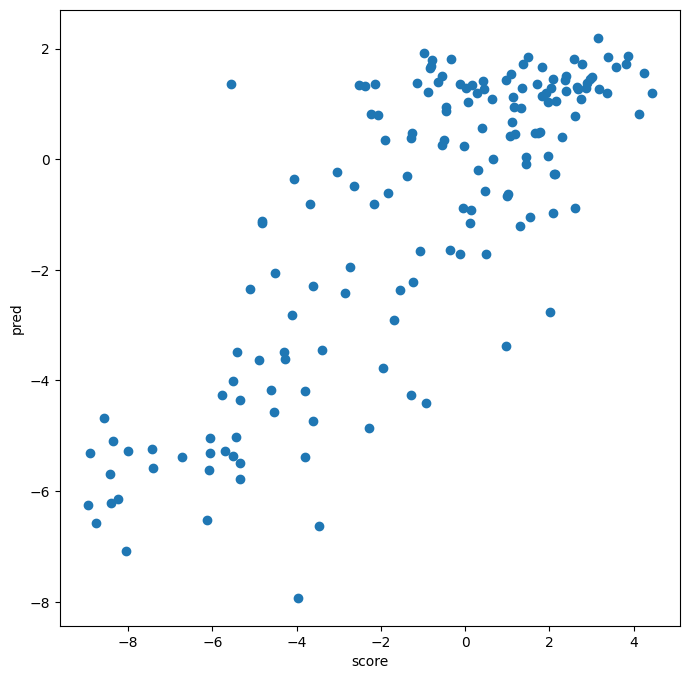

In [9]:
# e_test=pd.read_csv("test.csv")
sdf = e_test
plt.figure(figsize=(8, 8))
plt.scatter(e_test["score"], e_test["pred"], marker='o')
plt.xlabel("score")
plt.ylabel("pred")
plt.show()